In [3]:
import sys
import warnings

# 数値計算ライブり
import numpy as np 
import pandas as pd 

# モデル計算ライブラリ
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Kerasライブラリ
import tensorflow as  tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils

# その他
import copy

# データ読み込み
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# 氏名を区切る
df_train['NameTitle'] = df_train['Name'].str.split('(.*, )|(\\..*)').str[3]
df_test['NameTitle'] = df_test['Name'].str.split('(.*, )|(\\..*)').str[3]

# Msのクレンジング
df_train['NameTitle'].str.replace('Ms | Mlle','Miss')
df_train['NameTitle'].str.replace('Mme','Mr')
df_test['NameTitle'].str.replace('Ms | Mlle','Miss')

# Mrのクレンジング
df_train['NameTitle'].str.replace('Mme','Mr')
df_test['NameTitle'].str.replace('Mme','Mr')

# Mr/Mrs/Miss/Master以外のクレンジング
df_train['NameTitle'][~df_train['NameTitle'].str.contains('Mr|Mrs|Miss|Master')] = 'Other'
df_test['NameTitle'][~df_test['NameTitle'].str.contains('Mr|Mrs|Miss|Master')] = 'Other'

# 性別を整数に変換
le = LabelEncoder()
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_test['Sex'] = le.fit_transform(df_test['Sex'])

# 乗船料金の欠損値を補完
df_train['Fare'] = df_train['Fare'].fillna(df_train['Fare'].mean())
df_test['Fare'] = df_train['Fare'].fillna(df_train['Fare'].mean())

# 乗船場所の欠損値を補完
df_train['Embarked'] = df_train['Embarked'].fillna("S")
df_test['Embarked'] = df_test['Embarked'].fillna("S")

# 乗船場所を整数に変換
df_train['Embarked'] = le.fit_transform(df_train['Embarked'])
df_test['Embarked'] = le.fit_transform(df_test['Embarked'])

# キャビン番号を整数に変換
df_train['Cabin'] = df_train['Cabin'].fillna("None")
df_test['Cabin'] = df_test['Cabin'].fillna("None")
df_train['Cabin'] = le.fit_transform(df_train['Cabin'])
df_test['Cabin'] = le.fit_transform(df_test['Cabin'])

# チケット番号を整数に変換
df_train['Ticket'] = le.fit_transform(df_train['Ticket'])
df_test['Ticket'] = le.fit_transform(df_test['Ticket'])

# 氏名を整数に変換
df_train['NameTitle'] = le.fit_transform(df_train['NameTitle'])
df_test['NameTitle'] = le.fit_transform(df_test['NameTitle'])

# 家族人数を追加
df_train['FamilyNum'] = df_train['SibSp'] + df_train['Parch']+1
df_test['FamilyNum'] = df_test['SibSp'] + df_test['Parch']+1

# Mr/Mrs/Miss/Master/それ以外別に、年齢の欠損値を補完
ntitlelist = list(set(df_train['NameTitle']))
for nt in ntitlelist:
    my_mean = df_train['Age'][df_train['NameTitle'] == nt].mean()
    df_train['Age'][df_train['NameTitle'] == nt] = df_train['Age'][df_train['NameTitle'] == nt].fillna(my_mean)
    df_test['Age'][df_train['NameTitle'] == nt] = df_train['Age'][df_train['NameTitle'] == nt].fillna(my_mean)
    print(my_mean)

# 学習データ、評価データ    
features = list(df_train.columns.values)
features.remove('Name')
features.remove('PassengerId')
features.remove('Survived')

y = df_train['Survived']
x = df_train[features]

x_test = df_test[features]
X_train = x
y_train = y
y_train_c = np_utils.to_categorical(y_train)

# 決定木で、額数データ、評価データを分類する
clf2 = DecisionTreeClassifier()
clf2.fit(X_train.values, y_train)
train_data_result_dt = clf2.predict(X_train.values)
test_data_result_dt = clf2.predict(x_test.values)

# 分類したリーフNo
train_data_leafno = clf2.apply(X_train.values)
test_data_leafno = clf2.apply(x_test.values)

# ディープラーニングで予測した生存確率を格納する配列
train_data_proba = np.zeros(X_train.shape[0])
test_data_proba = np.zeros(x_test.shape[0])

# 決定木で分類したリーフNoごとに学習データ、評価データを分けて、
# ディープラーニングで生存確率を計算する
uniq_leafno = list(set(train_data_leafno))
for lfno in uniq_leafno:
    # リーフNoのデータ抽出
    idx_train = train_data_leafno == lfno
    idx_test = test_data_leafno == lfno
    # ディープラーニング
    if len(list(set(y_train[idx_train]))) == 2:
        model = Sequential()
        model.add(Dense(output_dim=256, input_dim=x.shape[1]))
        model.add(Activation("relu"))
        model.add(keras.layers.core.Dropout(0.3))
        model.add(Dense(output_dim=128))
        model.add(Activation("relu"))
        model.add(keras.layers.core.Dropout(0.2))
        model.add(Dense(output_dim=64))
        model.add(Activation("relu"))
        model.add(Dense(output_dim=2))
        model.add(Activation("softmax"))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        a = model.fit(X_train[idx_train].values, y_train_c[idx_train], nb_epoch=1500)
        train_p = model.predict_proba(X_train[idx_train].values)
        train_data_proba[idx_train] = train_p[:,1]
        
        if x_test[idx_test].shape[0] > 0:
            test_p = model.predict_proba(x_test[idx_test].values)
            test_data_proba[idx_test] = test_p[:,1]   
        
    else:
        train_data_proba[idx_train] = y_train[0]
        if X_train[idx_train].shape[0] > 0:
            test_data_proba[idx_test] = y_train[0]      

# ディープラーニングで予測した生存確率を、学習データ、評価データに結合する
X_train2 = pd.concat([X_train, pd.DataFrame(train_data_proba)], axis = 1)
X_test2 = pd.concat([x_test, pd.DataFrame(test_data_proba)], axis = 1)

#　勾配ブースティングで予測する
#　max_depthの最適値を計算する
param_test1 = {'max_depth':[3, 4, 5, 6, 8, 10 ]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X_train2, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# n_estimators(作成する木の数)の最適値を計算する
param_test2 = { "n_estimators":[40 ,50, 60, 70, 80, 90, 100]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(max_depth=gsearch1.best_params_['max_depth']), 
                        param_grid = param_test2, scoring='roc_auc',cv=5)
gsearch2.fit(X_train2, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

# 勾配ブースティング
gb = GradientBoostingClassifier(max_depth=gsearch1.best_params_['max_depth'], n_estimators=gsearch2.best_params_['n_estimators'])
gb.fit(X_train2, y_train)
classes = gb.predict(X_test2.values).astype(int)

# 予測結果をCSV出力
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": classes})

submission.to_csv('titanic_lin.csv', index=False)


4.574166666666667
21.773972602739725
32.368090452261306
35.898148148148145
42.38461538461539
Epoch 1/1500
3/3 [==============================] - 0s 113ms/step - loss: 10.6021 - acc: 0.0000e+00
Epoch 2/1500
3/3 [==============================] - 0s 665us/step - loss: 1.6319 - acc: 0.3333
Epoch 3/1500
3/3 [==============================] - 0s 664us/step - loss: 2.0617 - acc: 0.6667
Epoch 4/1500
3/3 [==============================] - 0s 665us/step - loss: 5.4178 - acc: 0.6667
Epoch 5/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 6/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3159 - acc: 0.6667
Epoch 7/1500
3/3 [==============================] - 0s 997us/step - loss: 5.4097 - acc: 0.6667
Epoch 8/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 9/1500
3/3 [==============================] - 0s 996us/step - loss: 4.2275 - acc: 0.6667
Epoch 10/1500
3/3 [============================

Epoch 86/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 87/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 88/1500
3/3 [==============================] - 0s 655us/step - loss: 5.3727 - acc: 0.6667
Epoch 89/1500
3/3 [==============================] - 0s 666us/step - loss: 5.3727 - acc: 0.6667
Epoch 90/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 91/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 92/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 93/1500
3/3 [==============================] - 0s 332us/step - loss: 5.3727 - acc: 0.6667
Epoch 94/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 95/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 96/1500
3/3 [=====================

Epoch 171/1500
3/3 [==============================] - 0s 655us/step - loss: 5.3727 - acc: 0.6667
Epoch 172/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 173/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 174/1500
3/3 [==============================] - 0s 332us/step - loss: 5.3727 - acc: 0.6667
Epoch 175/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 176/1500
3/3 [==============================] - 0s 999us/step - loss: 5.3727 - acc: 0.6667
Epoch 177/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 178/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 179/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 180/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 181/1500
3/3 [==========

Epoch 256/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 257/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 258/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 259/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 260/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 261/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 262/1500
3/3 [==============================] - 0s 666us/step - loss: 5.3727 - acc: 0.6667
Epoch 263/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 264/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 265/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 266/1500
3/3 [============

Epoch 341/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 342/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 343/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 344/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 345/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 346/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 347/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 348/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 349/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 350/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 351/1500
3/3 [============

Epoch 426/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 427/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 428/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 429/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 430/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 431/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 432/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 433/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 434/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 435/1500
3/3 [==============================] - 0s 999us/step - loss: 5.3727 - acc: 0.6667
Epoch 436/1500
3/3 [============

Epoch 511/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 512/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 513/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 514/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 515/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 516/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 517/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 518/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 519/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 520/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 521/1500
3/3 [============

Epoch 596/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 597/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 598/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 599/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 600/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 601/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 602/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 603/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 604/1500
3/3 [==============================] - 0s 662us/step - loss: 5.3727 - acc: 0.6667
Epoch 605/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 606/1500
3/3 [==========

Epoch 681/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 682/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 683/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 684/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 685/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 686/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 687/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 688/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 689/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 690/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 691/1500
3/3 [============

Epoch 766/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 767/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 768/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 769/1500
3/3 [==============================] - 0s 332us/step - loss: 5.3727 - acc: 0.6667
Epoch 770/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 771/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 772/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 773/1500
3/3 [==============================] - 0s 332us/step - loss: 5.3727 - acc: 0.6667
Epoch 774/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 775/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 776/1500
3/3 [==========

Epoch 851/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 852/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 853/1500
3/3 [==============================] - 0s 331us/step - loss: 5.3727 - acc: 0.6667
Epoch 854/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 855/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 856/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 857/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 858/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 859/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 860/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 861/1500
3/3 [==============

Epoch 936/1500
3/3 [==============================] - 0s 333us/step - loss: 5.3727 - acc: 0.6667
Epoch 937/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 938/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 939/1500
3/3 [==============================] - 0s 666us/step - loss: 5.3727 - acc: 0.6667
Epoch 940/1500
3/3 [==============================] - 0s 999us/step - loss: 5.3727 - acc: 0.6667
Epoch 941/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 942/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 943/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 944/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 945/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 946/1500
3/3 [============

Epoch 1021/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 1022/1500
3/3 [==============================] - 0s 656us/step - loss: 5.3727 - acc: 0.6667
Epoch 1023/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1024/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 1025/1500
3/3 [==============================] - 0s 655us/step - loss: 5.3727 - acc: 0.6667
Epoch 1026/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 1027/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 1028/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 1029/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1030/1500
3/3 [==============================] - 0s 2ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1031/1500
3/3 [=

Epoch 1105/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 1106/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1107/1500
3/3 [==============================] - 0s 995us/step - loss: 5.3727 - acc: 0.6667
Epoch 1108/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 1109/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1110/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1111/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 1112/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1113/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 1114/1500
3/3 [==============================] - 0s 666us/step - loss: 5.3727 - acc: 0.6667
Epoch 1115/1500
3/3 [=====

Epoch 1189/1500
3/3 [==============================] - 0s 652us/step - loss: 5.3727 - acc: 0.6667
Epoch 1190/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1191/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1192/1500
3/3 [==============================] - 0s 985us/step - loss: 5.3727 - acc: 0.6667
Epoch 1193/1500
3/3 [==============================] - 0s 665us/step - loss: 5.3727 - acc: 0.6667
Epoch 1194/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1195/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1196/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 1197/1500
3/3 [==============================] - 0s 663us/step - loss: 5.3727 - acc: 0.6667
Epoch 1198/1500
3/3 [==============================] - 0s 1ms/step - loss: 5.3727 - acc: 0.6667
Epoch 1199/1500
3/3 [=====

Epoch 1273/1500
3/3 [==============================] - 0s 666us/step - loss: 5.3727 - acc: 0.6667
Epoch 1274/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1275/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1276/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1277/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1278/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1279/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 1280/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1281/1500
3/3 [==============================] - 0s 997us/step - loss: 5.3727 - acc: 0.6667
Epoch 1282/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1283/1500
3/3 

Epoch 1357/1500
3/3 [==============================] - 0s 999us/step - loss: 5.3727 - acc: 0.6667
Epoch 1358/1500
3/3 [==============================] - 0s 994us/step - loss: 5.3727 - acc: 0.6667
Epoch 1359/1500
3/3 [==============================] - 0s 666us/step - loss: 5.3727 - acc: 0.6667
Epoch 1360/1500
3/3 [==============================] - 0s 999us/step - loss: 5.3727 - acc: 0.6667
Epoch 1361/1500
3/3 [==============================] - 0s 998us/step - loss: 5.3727 - acc: 0.6667
Epoch 1362/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1363/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1364/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1365/1500
3/3 [==============================] - 0s 657us/step - loss: 5.3727 - acc: 0.6667
Epoch 1366/1500
3/3 [==============================] - 0s 655us/step - loss: 5.3727 - acc: 0.6667
Epoch 1367/1500
3/3 

Epoch 1441/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1442/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1443/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1444/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1445/1500
3/3 [==============================] - 0s 996us/step - loss: 5.3727 - acc: 0.6667
Epoch 1446/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1447/1500
3/3 [==============================] - 0s 988us/step - loss: 5.3727 - acc: 0.6667
Epoch 1448/1500
3/3 [==============================] - 0s 332us/step - loss: 5.3727 - acc: 0.6667
Epoch 1449/1500
3/3 [==============================] - 0s 664us/step - loss: 5.3727 - acc: 0.6667
Epoch 1450/1500
3/3 [==============================] - 0s 999us/step - loss: 5.3727 - acc: 0.6667
Epoch 1451/1500
3/3 

C:\Users\youji\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\youji\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [2]:
print(gsearch1.best_params_)
print(gsearch2.best_params_)

{'max_depth': 3}
{'n_estimators': 70}


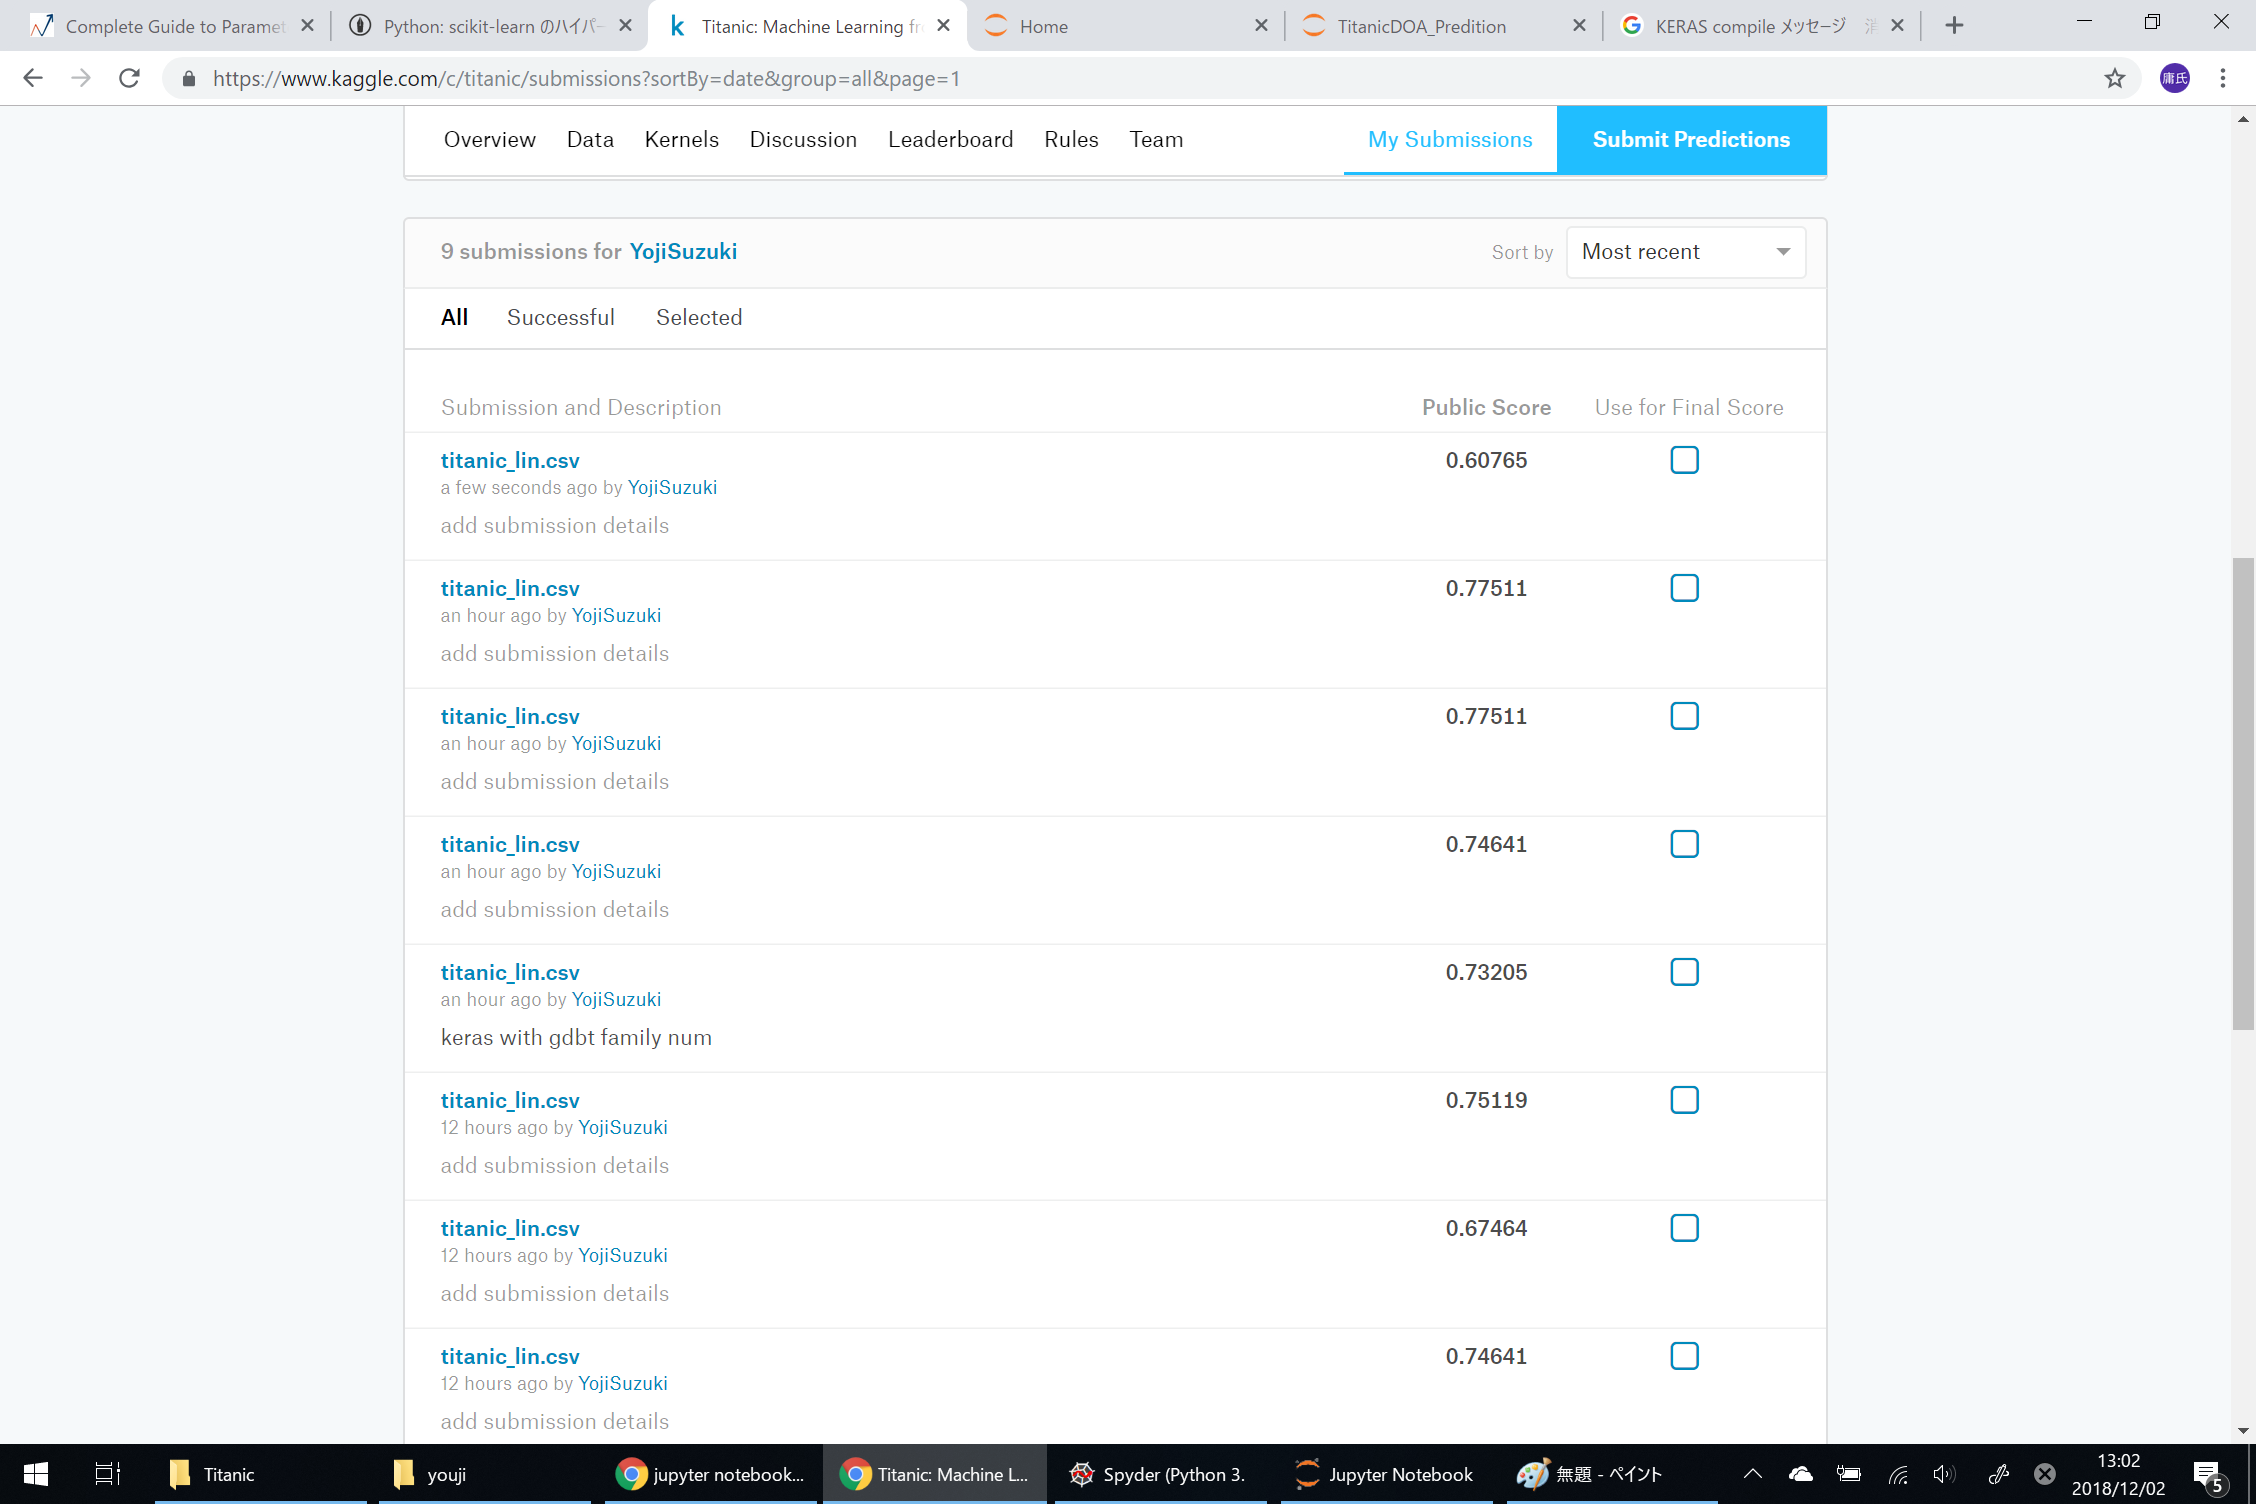

In [4]:
import os
import os.path
from IPython.display import display
from PIL import Image
path ="kaggle_result.png"
display(Image.open(path))